In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
#!pip install tensorflow
#!pip install keras

##  3. Fit a CNN model on the dataset which has been assigned to you. Print a classification report to see the model metrics on train and test datasets.

In [5]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

In [6]:
#This will setup my directories for all of the data files in the 100-bird-species dataset. 
BASE_DIR = 'C:/Users/GEETHU SUNNY/Downloads/archive (1)'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['birds latin names.csv', 'birds.csv', 'class_dict.csv', 'EfficientNetB4-BIRDS-0.99.h5', 'images to test', 'my_csv-2-17-2022-1-17-48.csv', 'test', 'train', 'valid']


In [7]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

400 CATEGORIES are  ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'AVADAVAT', 'AZURE JAY', 'AZURE TANAGER', 'AZURE TIT', 'BAIKAL TEAL', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAND TAILED GUAN', 'BANDED BROADBILL', 'BANDED PITA', 'BANDED STILT', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BARROWS GOLDENEYE', 'BAY-BREASTED WARBLER', 'BEARDED BARBE

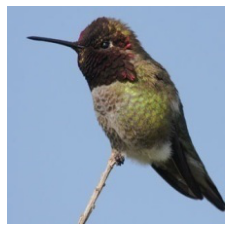

Figures are  (224, 224, 3)


In [8]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("C:/Users/GEETHU SUNNY/Downloads/archive (1)/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [9]:

#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, )


In [10]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 58388 images belonging to 400 classes.
data groups: 1825
Found 2000 images belonging to 400 classes.
data groups: 63
validation image qty: 2000
Found 2000 images belonging to 400 classes.
data groups: 63


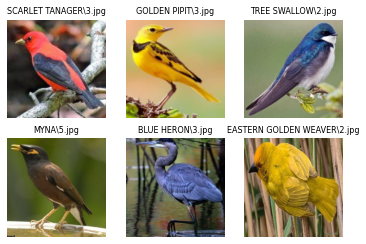

In [11]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

In [12]:
#This was my Sequential model from the CIFAR10 dataset - seemed like a good starting point. -65% accuracy
#With 2 epochs I got: Test loss: 2.3443613751181243 Test accuracy: 0.4788889
#With 50 epochs/stopped at 13 Test loss: 1.7568193797407479, Test accuracy: 0.5733333..Not so great. I will move on to pretrained models.
#Increased from 32 to 64 nodes in CONV2D layers: Test loss: 4.270853807186258, Test accuracy: 0.5377778
#Changed from Adam to sgd for optimizer:Test loss: 1.4400342908398858, Test accuracy: 0.65444446 - 65%
backend.clear_session()
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=SHAPE)) #224X224
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) #222x222
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #111x111
model.add(BatchNormalization())
model.add(Dropout(0.35)) #Doesn't appear to be working in the model summary.

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization()) 
model.add(Conv2D(64, (3, 3))) #109x109
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #54x54
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

model.add(Conv2D(64, (3, 3), padding='same')) #54x54
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(Category_count)) #Updated for number of classes
model.add(Activation('softmax'))

model.summary()

#Compile

model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                      

C:\Users\GEETHU SUNNY\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-12-e17b15c7a7ed>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
 151/1825 [=>............................] - ETA: 3:31:58 - loss: 5.9148 - accuracy: 0.0271

KeyboardInterrupt: 

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])